In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2024-02-29 12:06:55--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-29 12:06:55 (88.4 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [13]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


In [14]:
import tensorflow

In [15]:

# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-02-29 12:09:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.207, 64.233.183.207, 173.194.193.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G   210MB/s    in 6.5s    

2024-02-29 12:09:41 (237 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [16]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE,
                                                                                batch_size = 32,
                                                                                shuffle=True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [17]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)


In [22]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing  # Import preprocessing submodule

# Define data augmentation pipeline
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255)  # Rescale pixel values to [0,1]
], name="data_augmentation")


In [26]:
import tensorflow as tf

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)


In [27]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb7 (Functional  (None, None, None, 2560   64097687  
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 2560)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               258661    
                                                           

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitoring validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restoring the best weights of the model when training is stopped
)


model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=50, # fit for 5 epochs to keep experiments
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback,]) # save best model weights to file

Epoch 1/50
237/237 [==============================] - 451s 2s/step - loss: 3.2841 - accuracy: 0.2750 - val_loss: 2.4340 - val_accuracy: 0.4378
Epoch 2/50
237/237 [==============================] - 291s 1s/step - loss: 2.2366 - accuracy: 0.4628 - val_loss: 2.0808 - val_accuracy: 0.4915
Epoch 3/50
237/237 [==============================] - 318s 1s/step - loss: 1.9149 - accuracy: 0.5254 - val_loss: 2.0026 - val_accuracy: 0.5000
Epoch 4/50
237/237 [==============================] - 280s 1s/step - loss: 1.7285 - accuracy: 0.5632 - val_loss: 1.9569 - val_accuracy: 0.4968
Epoch 5/50
237/237 [==============================] - 229s 965ms/step - loss: 1.5752 - accuracy: 0.6054 - val_loss: 1.8886 - val_accuracy: 0.5204
Epoch 6/50
237/237 [==============================] - 255s 1s/step - loss: 1.4824 - accuracy: 0.6235 - val_loss: 1.8410 - val_accuracy: 0.5289
Epoch 7/50
237/237 [==============================] - 241s 1s/step - loss: 1.3744 - accuracy: 0.6478 - val_loss: 1.8520 - val_accuracy: 0.5

In [29]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 57s 72ms/step - loss: 1.5085 - accuracy: 0.5970


[1.5085054636001587, 0.5969901084899902]

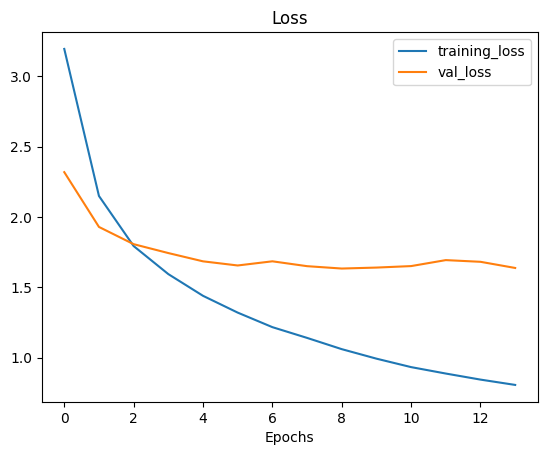

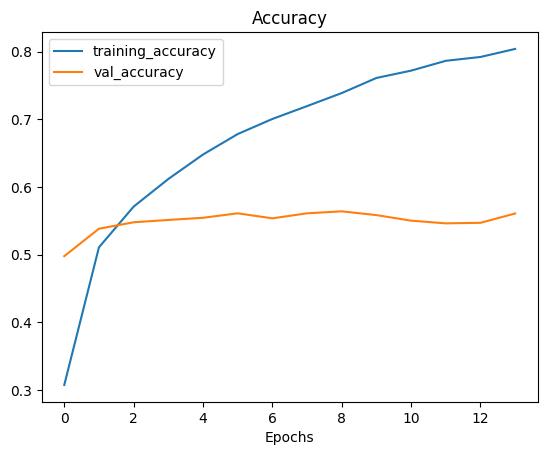

In [43]:
plot_loss_curves(history_all_classes_10_percent)


In [31]:

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def calculate_metrics_and_plot_confusion_matrix(model, test_data, class_names):
    # Predict probabilities for the test set
    y_probs = model.predict(test_data)
    # Predict labels for the test set
    y_preds = np.argmax(y_probs, axis=1)

    # Get true labels
    true_labels = []
    for _, y_true in test_data.unbatch():
        true_labels.append(y_true.numpy().argmax())

    # Calculate precision
    precision = precision_score(true_labels, y_preds, average='macro')
    # Calculate recall
    recall = recall_score(true_labels, y_preds, average='macro')
    # Calculate F1 score
    f1 = f1_score(true_labels, y_preds, average='macro')
    # Calculate confusion matrix
    conf_mat = confusion_matrix(true_labels, y_preds)

    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Confusion Matrix:\n", conf_mat)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

790/790 [==============================] - 72s 89ms/step
Precision: 0.6277968249252152
Recall: 0.596990099009901
F1 Score: 0.5957653183912845
Confusion Matrix:
 [[ 58   2  17 ...  16   3   9]
 [  0 193   0 ...   0   2   0]
 [ 15   3 152 ...   4   0   1]
 ...
 [  2   1   0 ... 160   0   0]
 [  1   1   0 ...   0  74   0]
 [  2   0   1 ...   5   1 168]]


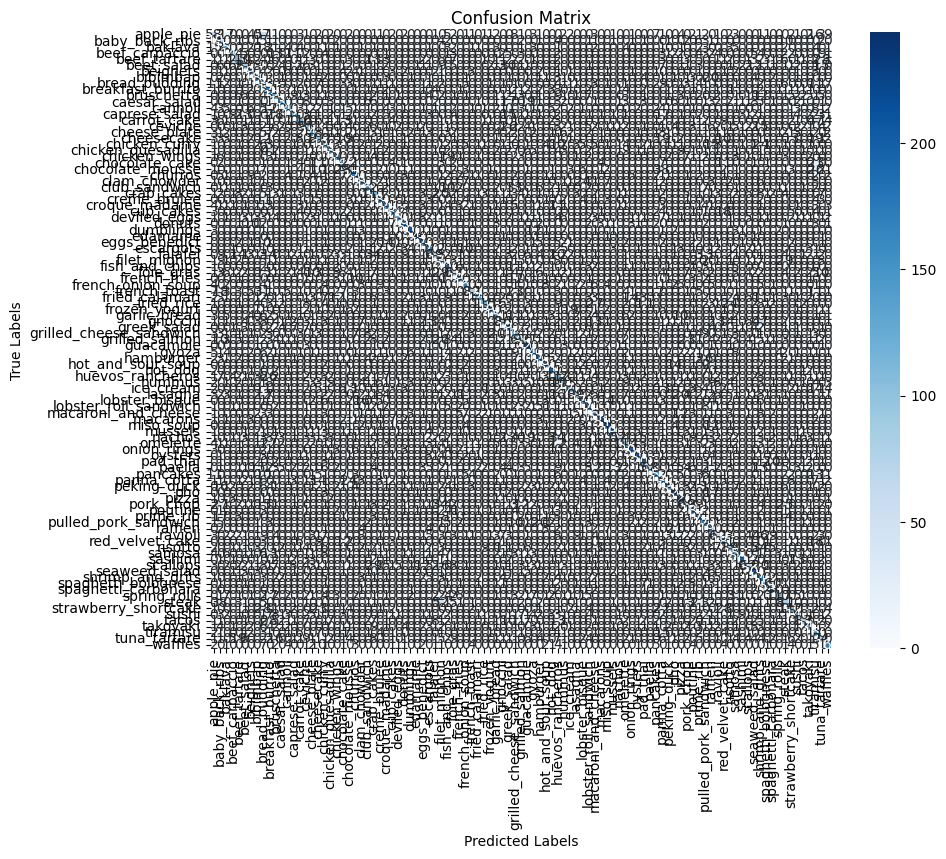

In [32]:
results_0 = calculate_metrics_and_plot_confusion_matrix(model, test_data, train_data_all_10_percent.class_names)
results_0

In [44]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [ ]:
base_model.summary()

In [47]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])


In [48]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=50,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks = [early_stopping]# validate on 15% of the test data
                                                    ) # start from previous last epoch


Epoch 1/50
237/237 [==============================] - 61s 206ms/step - loss: 0.8956 - accuracy: 0.7678 - val_loss: 1.6682 - val_accuracy: 0.5662
Epoch 2/50
237/237 [==============================] - 29s 121ms/step - loss: 0.8011 - accuracy: 0.7843 - val_loss: 1.7467 - val_accuracy: 0.5445
Epoch 3/50
237/237 [==============================] - 31s 130ms/step - loss: 0.7433 - accuracy: 0.7992 - val_loss: 1.7305 - val_accuracy: 0.5522
Epoch 4/50
237/237 [==============================] - 32s 132ms/step - loss: 0.6984 - accuracy: 0.8132 - val_loss: 1.6966 - val_accuracy: 0.5617
Epoch 5/50
237/237 [==============================] - 31s 128ms/step - loss: 0.6445 - accuracy: 0.8302 - val_loss: 1.7333 - val_accuracy: 0.5599
Epoch 6/50
237/237 [==============================] - 29s 121ms/step - loss: 0.5998 - accuracy: 0.8397 - val_loss: 1.7757 - val_accuracy: 0.5426


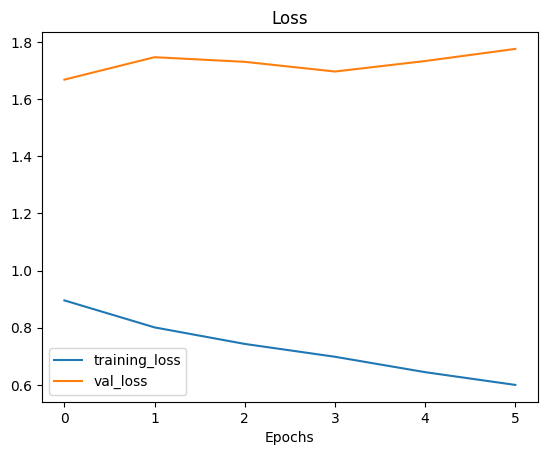

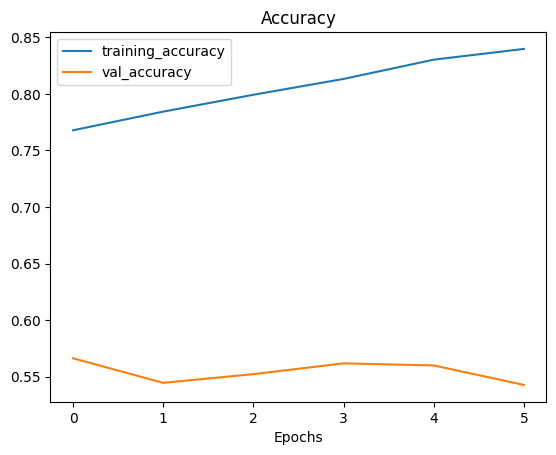

In [49]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)


In [54]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.mobilenet.MobileNet(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model1 = tf.keras.Model(inputs, outputs)


In [55]:
model1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 mobilenet_1.00_224 (Functi  (None, None, None, 1024   3228864   
 onal)                       )                                   
                                                                 
 global_average_pooling (Gl  (None, 1024)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               103525    
                                                           

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitoring validation loss
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restoring the best weights of the model when training is stopped
)


model1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-2), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_1 = model1.fit(train_data_all_10_percent,
                                           epochs= 50, # fit for 5 epochs to keep experiments
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback, early_stopping]) # save best model weights to file

Epoch 1/50
237/237 [==============================] - 81s 328ms/step - loss: 6.9850 - accuracy: 0.0383 - val_loss: 6.5433 - val_accuracy: 0.0315
Epoch 2/50
237/237 [==============================] - 65s 271ms/step - loss: 6.5279 - accuracy: 0.0602 - val_loss: 7.5751 - val_accuracy: 0.0188
Epoch 3/50
 36/237 [===>..........................] - ETA: 47s - loss: 6.1114 - accuracy: 0.0851

KeyboardInterrupt: 

In [ ]:
plot_loss_curves(history_1)


In [ ]:
results_1 = calculate_metrics_and_plot_confusion_matrix(model1, test_data, train_data_all_10_percent.class_names)
results_1